# Integration geospatial raster-vector data in VKG system Ontop

## 0. Imports

In [16]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import LineString, MultiPolygon, Polygon, box, MultiPoint, Point
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.geos_version_string}")

Py version 3.8.10
Shapely version 3.11.1


## 1. Functions

In [250]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_polygon_02(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    coordinates = list(zip(x_grid, y_grid))
    polygon = "POLYGON((" + ", ".join(f"{y} {x}" for x, y in coordinates) + "))"
    return polygon

def wktDisplay(polygon):
    # Create plot object just like standard WKTPlot class
    plot = OpenStreetMapsPlot("Open Street Map Plot", 
                              height=600,
                              width=600,
                              disable_mercator=False)
    plot.add_shape(polygon, fill_alpha=0.5, fill_color="firebrick")
    plot.show()
    
def GetExtent(ds):
    """ Return list of corner coordinates from a gdal Dataset """
    xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
    width, height = ds.RasterXSize, ds.RasterYSize
    xmax = xmin + width * xpixel
    ymin = ymax + height * ypixel
    extent_dict = {
      'lons_width': width, 
      'lats_height': height, 
      'xpixel': xpixel, 
      'ypixel': ypixel,
      'Upper_Left':[xmin, ymax],
      'Bottom_Left':[xmin, ymin],
      'Upper_Right':[xmax, ymax],
      'Bottom_Right':[xmax, ymin]        
    }
    return extent_dict
    #return (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin), (xpixel, ypixel), (width, height)
   
def geo2grid(lons, lats, upper_left_lon_x, upper_left_lat_y, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(upper_left_lon_x, pixel_size, xskew, upper_left_lat_y, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)
    print(xs)
    print(ys)
    return xs, ys 

def add_closing_coordinates(d):
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

# def add_closing_coordinates_v02(d):
#     """ Adds the first 'lat long' to the end"""
#     if d.geom_type == 'Polygon':
#         i = re.search(r"\d", d).start()
#         j = re.search(r'(\d)[^\d]*$', d).start() + 1
#         c = d.index(',')    
#         return d[:j] + ", " + d[i:c] + d[j:]

def add_closing_coordinates_holes(d):
    """ Adds the first 'lat long' to the end for polygons with one hole"""
    # Find the start of the first set of coordinates in the exterior ring
    i_exterior = re.search(r"\d", d).start()
    
    # Find the end of the interior ring (hole)
    j_interior = re.search(r'(\d)[^\d]*$', d).start() + 1
    
    # Find the comma separating the lat and long in the exterior ring
    c_exterior = d.index(',')

    # Find the comma separating the lat and long in the interior ring
    c_interior = d[j_interior:].index(',') + j_interior
    
    # Concatenate the exterior ring and the first set of coordinates to close it
    result = d[:c_exterior] + d[i_exterior:c_exterior] + d[c_exterior:]

    # Concatenate the interior ring and the first set of coordinates to close it
    result = result[:c_interior] + d[i_exterior:c_exterior] + result[c_interior:]

    return result


def geoPOLYGON_to_gridPOLYGON(polygon_str):
    data = str(polygon_str)
    data_wkt = add_closing_coordinates(data)
    polygon = wkt.loads(data_wkt)
    coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
    expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
    lat_arr = []
    long_arr = []
    for i in range(len(expected_list_of_coordinates_for_received_code)):
        long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
        lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])
    
    long_list = long_arr.tolist()
    lat_list = lat_arr.tolist()
    
    return long_list, lat_list

def geoPOLYGON_to_gridPOLYGON_02(polygon_str):
    lat_arr = []
    long_arr = []
    if polygon_str.geom_type == 'Polygon':
        data = str(polygon_str)
        data_wkt = add_closing_coordinates(data)
        polygon = wkt.loads(data_wkt)
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()
        return long_list, lat_list
    else:
        return None  # skip if Multipolygon

def breakMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        return str("")
    else:
        for polygon in multipolygon.geoms:
            polygons_array.append(polygon)

#     print("# of internal polygons is ",len(polygons_array))
    return polygons_array

def checkMULTIPOLYGONS(df):
   """checks if a vector data has multipolygons"""
   df = df.assign(isMULTI=df['geometry'].apply(lambda row :len(breakMULTIPOLYGONS(wkt.loads(str(row))))))
   df_multipolygons = df[df['isMULTI'] > 0]
   view = pd.DataFrame({'Districts':df_multipolygons['NAME_2'],'MultiPolygons':df_multipolygons['isMULTI']})
   return view

######## GIS F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return float("{}".format(result))

def visuallizeARRAY(data, title="Beautiful Image but please put a signifaciant title"):
    """accept an array and return shape and visualize the array in heat map"""
    data = np.array(data)
    if len(data.shape) > 1:
        ax = sns.heatmap(np.array(data) , cmap = 'Spectral_r') #inferno
    else:
        ax = sns.heatmap(data[:, np.newaxis], cmap='Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return np.array(data).shape

## 2. Explainatory Data Analysis

### 2.1 Geometric Vector Data (relational data)

In [120]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Baveria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')

In [27]:
view = pd.DataFrame({'Districts':gdfBAV['NAME_2'],'geom':gdfBAV['geometry']})
view

,Districts,geom
0,Aichach-Friedberg,"POLYGON ((11.03899 48.22127, 11.04266 48.22036..."
1,Altötting,"POLYGON ((12.61187 48.06424, 12.60968 48.06479..."
2,Amberg,"POLYGON ((11.78115 49.42765, 11.78099 49.42811..."
3,Amberg-Sulzbach,"POLYGON ((11.96819 49.61406, 11.96912 49.61361..."
4,Ansbach,"POLYGON ((10.66370 49.08374, 10.66685 49.08319..."
...,...,...
91,Weilheim-Schongau,"POLYGON ((10.97286 47.69561, 10.97356 47.69552..."
92,Weißenburg-Gunzenhausen,"POLYGON ((11.04477 48.90070, 11.04352 48.89983..."
93,Wunsiedel im Fichtelgebirge,"POLYGON ((11.90024 49.98885, 11.89903 49.98987..."
94,Würzburg,"POLYGON ((9.93395 49.48361, 9.92981 49.48433, ..."


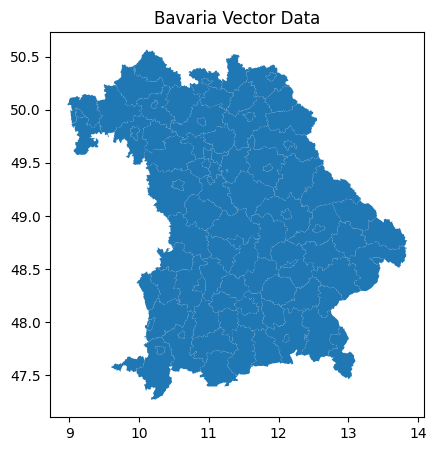

In [55]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfBAV.plot(ax=ax1)
# Add a title to your plot
ax1.set(title="Bavaria Vector Data")
plt.show()

In [124]:
# gdfBAV_multipolygons = gdfBAV[gdfBAV['isMULTI'] > 0]
# view = pd.DataFrame({'Districts':gdfBAV_multipolygons['NAME_2'],'MultiPolygons':gdfBAV_multipolygons['isMULTI']})
# view

In [121]:
checkMULTIPOLYGONS(gdfSWE)

,Districts,MultiPolygons
0,Ödeshög,3
1,Åtvidaberg,2
2,Boxholm,2
8,Norrköping,88
9,Söderköping,133
...,...,...
275,Tanum,122
276,Tibro,2
278,Tjörn,54
281,Uddevalla,24


### 2.2 Raster Data (multi-dimensional arrays)

#### 2.1.1 Geotiff

#### 2.2.2 NetCDF

In [21]:
raster01_path = '/home/arkaghosh/Downloads/Baveria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'

In [22]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [23]:
upper_right_lon_x = float(f['lon'].max())
lower_left_lat_y = float(f['lat'].min())

lower_left_lon_x = float(f['lon'].min())
upper_right_lat_y = float(f['lat'].max())

#### 2.2.3 RasDaMan

In [4]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [6]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list

In [8]:
collection_list = list(collection_list)
collection_list

['AIR_TEMP_X',
 'World_Air_Temperature',
 'LST_03_GeoTIFF_FLIPPED',
 'Baveria_Temperature_MODIS_1km',
 'Surface_Temperature_Sweden_061',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'Surface_Temperature_Sweden',
 'LST_03_GeoTIFF',
 'Surface_Temperature_Sweden_lon_lat']

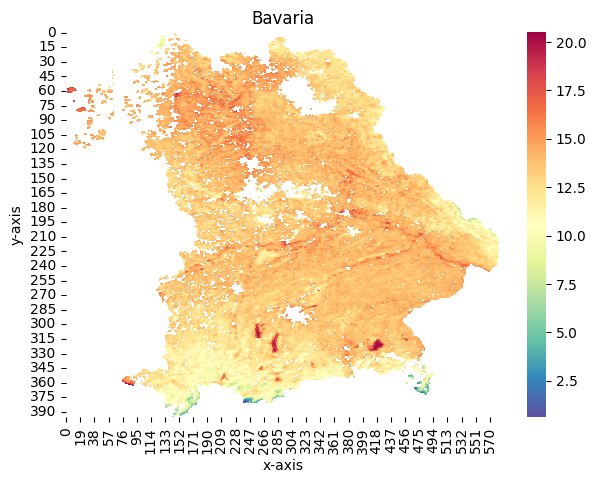

True

In [33]:
q = "select (mr[178, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria",0)

## 3. Resolving Issues

### ISSUE #01: Automate Metadata Retrival for each raster

#### Necessary Metadata for raster data

In [152]:
upper_right_lat_y
lower_left_lat_y
upper_right_lon_x 
lower_left_lon_x
pixel_size = 0.00833333333258679

### ISSUE #02: Resolving Multipolygons in Vector Data

Some tips:

 1. https://blogs.sap.com/2016/08/30/importing-shapefiles-in-sap-hana-and-the-validity-of-geometries/

In [123]:
checkMULTIPOLYGONS(gdfBAV)

,Districts,MultiPolygons
12,Bamberg,2
15,Bayreuth (Kreisfreie Stadt),2
16,Berchtesgadener Land,2
17,Cham,8
59,München (Kreisfreie Stadt),2
65,Nürnberg,2
67,Oberallgäu,2
68,Ostallgäu,2
75,Rhön-Grabfeld,2
76,Rosenheim,4


### Rosenheim

Rosenheim


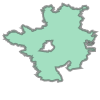

In [246]:
gid = 76 # 58 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [229]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.2 47.64, 12.201 47.638, 12.201 47.637, 12.202 47.636, 12.202 4...>,
 <POLYGON ((12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47...>,
 <POLYGON ((12.415 47.868, 12.415 47.868, 12.415 47.869, 12.416 47.869, 12.41...>,
 <POLYGON ((12.425 47.876, 12.426 47.876, 12.426 47.876, 12.426 47.876, 12.42...>]

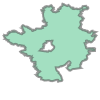

In [230]:
mulPOLY[0]

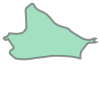

In [231]:
mulPOLY[1]

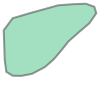

In [232]:
mulPOLY[2]

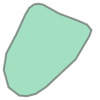

In [233]:
mulPOLY[3]

In [251]:
longs,lats = geoPOLYGON_to_gridPOLYGON_02(INPUT)
# x_grid, y_grid = geo2grid(longs, lats, lower_left_lon_x, upper_right_lat_y, pixel_size)
# gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

TypeError: cannot unpack non-iterable NoneType object

In [236]:
mulPOLY[0].geom_type

'Polygon'

In [162]:
print(mulPOLY[2])

POLYGON ((12.415458999000123 47.86782500000004, 12.41544000100015 47.86842300000012, 12.4154190000001 47.868996000000095, 12.415777000000048 47.86947600000002, 12.416507000000081 47.86969000000016, 12.417579001000036 47.86998700100014, 12.418174999000144 47.870032999000045, 12.418684000000098 47.8700520000001, 12.419018807000157 47.869930071000056, 12.419097863000104 47.86967480100009, 12.418824000000086 47.86927800000018, 12.418429000000117 47.86894200000012, 12.418362535000028 47.868883106, 12.417989729999988 47.86855316300017, 12.417735356000094 47.868230895000124, 12.41772199900015 47.86821400000008, 12.417699215000027 47.86818711200016, 12.41741085100017 47.86784744200014, 12.417059899000094 47.867538453000066, 12.41672614099997 47.86736208100018, 12.416540000000111 47.8672639990001, 12.416113000000166 47.86718400000012, 12.415944726000077 47.86718746400004, 12.41577339200012 47.867191314000195, 12.41564295600017 47.86727234200015, 12.415521999000191 47.86734799999999, 12.41545899

In [164]:
add_closing_coordinates(str(mulPOLY[2]))

'POLYGON ((12.415458999000123 47.86782500000004, 12.41544000100015 47.86842300000012, 12.4154190000001 47.868996000000095, 12.415777000000048 47.86947600000002, 12.416507000000081 47.86969000000016, 12.417579001000036 47.86998700100014, 12.418174999000144 47.870032999000045, 12.418684000000098 47.8700520000001, 12.419018807000157 47.869930071000056, 12.419097863000104 47.86967480100009, 12.418824000000086 47.86927800000018, 12.418429000000117 47.86894200000012, 12.418362535000028 47.868883106, 12.417989729999988 47.86855316300017, 12.417735356000094 47.868230895000124, 12.41772199900015 47.86821400000008, 12.417699215000027 47.86818711200016, 12.41741085100017 47.86784744200014, 12.417059899000094 47.867538453000066, 12.41672614099997 47.86736208100018, 12.416540000000111 47.8672639990001, 12.416113000000166 47.86718400000012, 12.415944726000077 47.86718746400004, 12.41577339200012 47.867191314000195, 12.41564295600017 47.86727234200015, 12.415521999000191 47.86734799999999, 12.4154589

### München (Kreisfreie Stadt)

München (Kreisfreie Stadt)


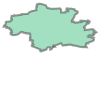

In [94]:
gid = 59 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [95]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((11.557 48.079, 11.555 48.079, 11.555 48.08, 11.557 48.081, 11.559...>,
 <POLYGON ((11.405 48.202, 11.405 48.202, 11.407 48.202, 11.416 48.203, 11.41...>]

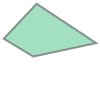

In [96]:
mulPOLY[0]

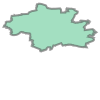

In [97]:
mulPOLY[1]

### Cham

Cham


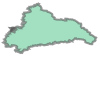

In [80]:
gid = 17 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [81]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.495 49.061, 12.494 49.061, 12.493 49.06, 12.493 49.06, 12.493 ...>,
 <POLYGON ((12.372 49.237, 12.372 49.237, 12.374 49.238, 12.374 49.238, 12.37...>,
 <POLYGON ((12.379 49.241, 12.381 49.241, 12.385 49.241, 12.385 49.24, 12.381...>,
 <POLYGON ((12.371 49.243, 12.373 49.245, 12.373 49.245, 12.376 49.245, 12.37...>,
 <POLYGON ((12.395 49.25, 12.395 49.25, 12.392 49.251, 12.392 49.251, 12.39 4...>,
 <POLYGON ((12.368 49.26, 12.37 49.259, 12.37 49.259, 12.372 49.26, 12.373 49...>,
 <POLYGON ((12.385 49.267, 12.385 49.267, 12.387 49.267, 12.387 49.267, 12.38...>,
 <POLYGON ((12.408 49.264, 12.408 49.264, 12.407 49.264, 12.405 49.264, 12.40...>]

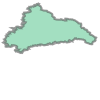

In [82]:
mulPOLY[0]

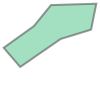

In [83]:
mulPOLY[1]

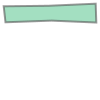

In [84]:
mulPOLY[2]

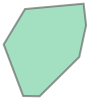

In [86]:
mulPOLY[3]

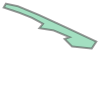

In [87]:
mulPOLY[4]

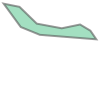

In [88]:
mulPOLY[5]

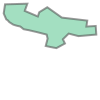

In [89]:
mulPOLY[6]

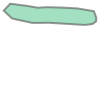

In [90]:
mulPOLY[7]

In [98]:
# Assuming df is your DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie', 'David'],
        'Age': [23, 28, 22, 30],
        'City': ['New York', 'San Francisco', 'Los Angeles', 'Chicago']}
df = pd.DataFrame(data)

# Filtering the DataFrame for rows where age > 25
filtered_df = df[df['Age'] > 25]

# Displaying the filtered DataFrame
print(filtered_df)

    Name  Age           City
1    Bob   28  San Francisco
3  David   30        Chicago


In [99]:
print(df)

      Name  Age           City
0    Alice   23       New York
1      Bob   28  San Francisco
2  Charlie   22    Los Angeles
3    David   30        Chicago


## 4. Source Preparaiton